# Demand Forecasting & Inventory Optimization for DataCo Global

## Notebook 02: Exploratory Data Analysis & ABC-XYZ Segmentation

---

**Project:** End-to-End Supply Chain Analytics  
**Dataset:** DataCo Smart Supply Chain Dataset  

---

### Notebook Series

| Notebook | Description | Status |
|----------|-------------|--------|
| 01_Data_Cleaning | Data loading, cleaning, and validation | Complete |
| **02_EDA_ABC_XYZ** | Exploratory analysis and product segmentation | Current |
| 03_Forecasting_Models | Demand forecasting model development | Next |
| 04_Inventory_Optimization | Safety stock and reorder point calculation | Pending |

---

### Objectives

1. Aggregate demand to weekly level for pattern analysis
2. Visualize demand over time to identify trends/seasonality
3. Detect and handle data anomalies
4. ABC Analysis: Classify products by revenue contribution
5. XYZ Analysis: Classify products by demand variability
6. ABC-XYZ Matrix: Create segmented inventory strategies

### Table of Contents

1. [Setup & Data Loading](#1-setup--data-loading)
2. [Weekly Demand Aggregation](#2-weekly-demand-aggregation)
3. [Demand Pattern Analysis](#3-demand-pattern-analysis)
4. [Anomaly Detection & Filtering](#4-anomaly-detection--filtering)
5. [ABC Analysis](#5-abc-analysis)
6. [XYZ Analysis](#6-xyz-analysis)
7. [ABC-XYZ Matrix](#7-abc-xyz-matrix)
8. [Export Results](#8-export-results)

---

## 1. Setup & Data Loading

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load cleaned data from previous notebook
df_clean = pd.read_csv('data/processed/df_clean.csv')
df_clean['order date (DateOrders)'] = pd.to_datetime(df_clean['order date (DateOrders)'])

print("Data loaded successfully!")
print(f"Records: {len(df_clean):,}")
print(f"Date Range: {df_clean['order date (DateOrders)'].min().date()} to {df_clean['order date (DateOrders)'].max().date()}")

Data loaded successfully!
Records: 79,107
Date Range: 2015-01-01 to 2018-01-31


## 2. Weekly Demand Aggregation

Convert individual orders into weekly totals for pattern analysis. Weekly aggregation balances granularity with noise reduction.

In [24]:
# Task 1: Aggregate Demand to Weekly Level
df_clean['order date (DateOrders)'] = pd.to_datetime(df_clean['order date (DateOrders)'])

df_weekly = df_clean.resample('W', on='order date (DateOrders)').agg({
    'Order Item Quantity': 'sum',
    'Sales': 'sum',
    'Order Id': 'count'
})

print("Weekly Aggregated Data:")
print("=" * 50)
print(f"Total Weeks: {len(df_weekly)}")
print(df_weekly.head(10))
print(f"\nWeekly Demand Statistics:")
print(df_weekly['Order Item Quantity'].describe().round(2))

Weekly Aggregated Data:
Total Weeks: 162
                         Order Item Quantity          Sales  Order Id
order date (DateOrders)                                              
2015-01-04                               622   53839.481021       279
2015-01-11                              1139   98678.471777       501
2015-01-18                              1226  105222.731933       542
2015-01-25                              1162  106085.512101       529
2015-02-01                              1219  103188.382020       551
2015-02-08                              1162  103396.622109       553
2015-02-15                               949   88680.191859       446
2015-02-22                              1250  109714.301946       541
2015-03-01                              1176  109406.532285       558
2015-03-08                              1217  104886.811998       543

Weekly Demand Statistics:
count     162.00
mean     1037.54
std       309.06
min        95.00
25%      1055.50
50%    

**Result:** 79,107 orders aggregated into 162 weeks (Jan 2015 - Jan 2018).

**Weekly Demand Profile:** Mean = 1,038 units, Std Dev = 309 units

**Coefficient of Variation (CV):** CV = (Std Dev / Mean) x 100 = 29.8% (moderate variability)

## 3. Demand Pattern Analysis

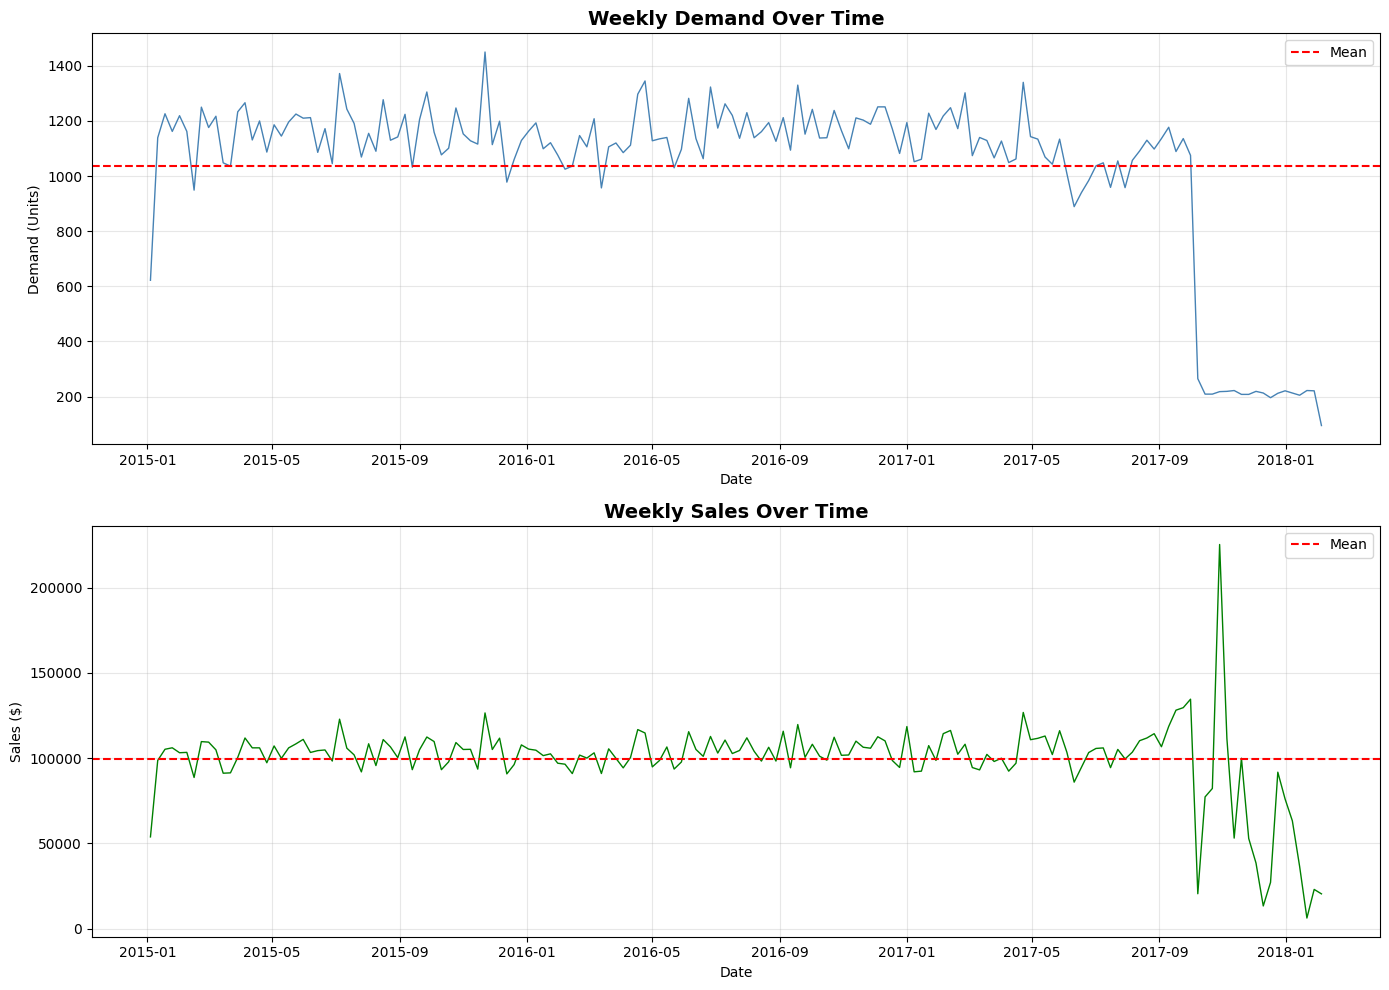

In [25]:
import matplotlib.pyplot as plt

# Task 2: Visualize Demand Over Time
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Weekly Demand Time Series
axes[0].plot(df_weekly.index, df_weekly['Order Item Quantity'], color='steelblue', linewidth=1)
axes[0].axhline(df_weekly['Order Item Quantity'].mean(), color='red', linestyle='--', label='Mean')
axes[0].set_title('Weekly Demand Over Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Demand (Units)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Weekly Sales Time Series
axes[1].plot(df_weekly.index, df_weekly['Sales'], color='green', linewidth=1)
axes[1].axhline(df_weekly['Sales'].mean(), color='red', linestyle='--', label='Mean')
axes[1].set_title('Weekly Sales Over Time', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Sales ($)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Anomaly Detection & Filtering

In [26]:
# Investigate late 2017 drop
print("Investigating Late 2017 Anomaly:")
print("=" * 50)

# Check last 20 weeks
print("\nLast 20 Weeks of Data:")
print(df_weekly.tail(20)[['Order Item Quantity', 'Sales']].round(2))

# Compare periods
print("\n\nPeriod Comparison:")
print("-" * 50)

# Before drop (2015-01 to 2017-09)
before = df_weekly[df_weekly.index < '2017-10-01']['Order Item Quantity']
print(f"Before Oct 2017: Mean = {before.mean():.0f}, Count = {len(before)} weeks")

# After drop (2017-10 onwards)
after = df_weekly[df_weekly.index >= '2017-10-01']['Order Item Quantity']
print(f"After Oct 2017:  Mean = {after.mean():.0f}, Count = {len(after)} weeks")

Investigating Late 2017 Anomaly:

Last 20 Weeks of Data:
                         Order Item Quantity      Sales
order date (DateOrders)                                
2017-09-24                              1136  129617.45
2017-10-01                              1075  134578.42
2017-10-08                               265   20505.23
2017-10-15                               209   77287.11
2017-10-22                               209   82229.10
2017-10-29                               218  225281.90
2017-11-05                               219  111536.96
2017-11-12                               222   53129.96
2017-11-19                               208   99961.78
2017-11-26                               208   52909.45
2017-12-03                               219   38524.20
2017-12-10                               213   13343.02
2017-12-17                               196   27179.17
2017-12-24                               212   91777.66
2017-12-31                               221   

**Observation:** Demand was stable (~1,141 units/week) from Jan 2015 to Oct 2017, then dropped 78% to ~255 units/week.

**Evidence of Anomaly:** 
- Sudden 75% drop in one week (Oct 1-8, 2017)
- Erratic sales-per-unit ratio after drop ($63 to $1,033/unit)
- No similar pattern in 2015 or 2016 (not seasonal)

**Likely Cause:** Data quality issue or incomplete data collection in later period.

**Decision:** Filter data to before Oct 8, 2017.

In [27]:
# Filter to stable period (before Oct 8, 2017)
# Create filtered order-level data (use this for ALL analyses)
df_clean_filtered = df_clean[df_clean['order date (DateOrders)'] < '2017-10-08'].copy()

# Aggregate to weekly for statistics
weekly_stats = df_clean_filtered.resample('W', on='order date (DateOrders)')['Order Item Quantity'].sum()

print("Filtered Data Summary:")
print("=" * 50)
print(f"Original orders:  {len(df_clean):,}")
print(f"Filtered orders:  {len(df_clean_filtered):,}")
print(f"Orders removed:   {len(df_clean) - len(df_clean_filtered):,}")
print(f"Date range:       {df_clean_filtered['order date (DateOrders)'].min().date()} to {df_clean_filtered['order date (DateOrders)'].max().date()}")

print(f"\nWeekly Demand Statistics:")
print("-" * 50)
print(f"Total weeks:      {len(weekly_stats)}")
print(f"Mean:             {weekly_stats.mean():.0f} units/week")
print(f"Std Dev:          {weekly_stats.std():.0f} units")
print(f"CV:               {(weekly_stats.std() / weekly_stats.mean() * 100):.1f}%")
print(f"Min:              {weekly_stats.min():.0f} units")
print(f"Max:              {weekly_stats.max():.0f} units")

Filtered Data Summary:
Original orders:  79,107
Filtered orders:  75,564
Orders removed:   3,543
Date range:       2015-01-01 to 2017-10-07

Weekly Demand Statistics:
--------------------------------------------------
Total weeks:      145
Mean:             1135 units/week
Std Dev:          127 units
CV:               11.1%
Min:              232 units
Max:              1450 units


**Data Filtering: Late 2017 Anomaly Removed**

**Action:** Filtered order-level data to before Oct 8, 2017, removing anomaly period.

**Key Finding:** CV = 11.1% indicates low variability (< 20%), confirming demand is stable and suitable for forecasting.

**Single Dataset:** df_clean_filtered is used for ALL analyses (ABC, XYZ).

## 5. ABC Analysis

**Concept:** ABC Analysis categorizes products based on revenue contribution using the Pareto Principle (80/20 rule).

| Category | Revenue Contribution | Products | Priority |
|----------|---------------------|----------|----------|
| **A** | Top 80% | ~20% | Highest |
| **B** | Next 15% | ~30% | Medium |
| **C** | Bottom 5% | ~50% | Lowest |

In [42]:
# Task 3: ABC Analysis

# Step 1: Calculate total revenue per product
product_revenue = df_clean_filtered.groupby('Product Name')['Sales'].sum().sort_values(ascending=False)

# Step 2: Calculate cumulative percentage
cumulative_pct = (product_revenue.cumsum() / product_revenue.sum() * 100).round(2)

# Step 3: Assign ABC category
def assign_abc(cum_pct):
    if cum_pct <= 80:
        return 'A'
    elif cum_pct <= 95:
        return 'B'
    else:
        return 'C'

# Step 4: Create ABC summary dataframe
abc_df = pd.DataFrame({
    'Revenue': product_revenue,
    'Cumulative_Pct': cumulative_pct,
    'ABC_Category': cumulative_pct.apply(assign_abc)
})


# Display results

print("\nABC Analysis (Filtered Data):")
print("=" * 50)
print(f"Total Products: {len(abc_df)}")
print(f"Total Revenue: ${product_revenue.sum():,.2f}")
print("\nCategory Summary:")
print(abc_df.groupby('ABC_Category').agg({'Revenue': ['count', 'sum']}).round(2))


ABC Analysis (Filtered Data):
Total Products: 102
Total Revenue: $15,018,587.25

Category Summary:
             Revenue             
               count          sum
ABC_Category                     
A                  6  11106577.64
B                  5   3143810.40
C                 91    768199.21


**ABC Analysis Explained**

**Definition:** ABC Analysis categorizes products by revenue contribution based on Pareto Principle (80/20 rule).

**Categories:**
- **A Items:** Top 80% of revenue, ~20% of products - Vital few, highest priority
- **B Items:** Next 15% of revenue, ~30% of products - Moderate importance
- **C Items:** Bottom 5% of revenue, ~50% of products - Trivial many, lowest priority

**Why It Matters:**
- Focus resources where they generate most value
- A items get sophisticated forecasting, careful safety stock optimization, frequent review
- C items use simple rules, minimal stock, infrequent review

**ABC Analysis Results**

| Category | Products | % Products | Revenue | % Revenue |
|----------|----------|------------|---------|-----------|
| A | 6 | 5.9% | $11.1M | 74.0% |
| B | 5 | 4.9% | $3.1M | 20.9% |
| C | 91 | 89.2% | $0.8M | 5.1% |

**Key Finding:** Just 6 products (5.9%) generate 74.0% of revenue - even more concentrated than typical 80/20 rule!

In [43]:
# Check top 10 products 
print("Top 10 Products:")
print(abc_df.head(10))

Top 10 Products:
                                                    Revenue  Cumulative_Pct  \
Product Name                                                                  
Field & Stream Sportsman 16 Gun Fire Safe      3.022249e+06           20.12   
Perfect Fitness Perfect Rip Deck               1.929578e+06           32.97   
Diamondback Women's Serene Classic Comfort Bi  1.802880e+06           44.98   
Nike Men's Free 5.0+ Running Shoe              1.627337e+06           55.81   
Nike Men's Dri-FIT Victory Golf Polo           1.387000e+06           65.05   
Pelican Sunstream 100 Kayak                    1.337533e+06           73.95   
Nike Men's CJ Elite 2 TD Football Cleat        1.278972e+06           82.47   
O'Brien Men's Neoprene Life Vest               1.257647e+06           90.84   
Under Armour Girls' Toddler Spine Surge Runni  5.518620e+05           94.52   
LIJA Women's Eyelet Sleeveless Golf Polo       2.782000e+04           94.70   

                                  

## 6. XYZ Analysis

**Concept:** XYZ Analysis categorizes products by demand variability using Coefficient of Variation (CV).

| Category | CV Range | Demand Pattern | Forecasting |
|----------|----------|----------------|-------------|
| **X** | < 0.5 | Stable | Easy |
| **Y** | 0.5-1.0 | Variable | Moderate |
| **Z** | > 1.0 | Erratic | Difficult |

**CV Formula:** CV = Standard Deviation / Mean

In [30]:
# Task 4: XYZ Analysis

# Step 1: Aggregate to weekly demand PER PRODUCT
product_weekly = df_clean_filtered.groupby([
    pd.Grouper(key='order date (DateOrders)', freq='W'),
    'Product Name'
])['Order Item Quantity'].sum().reset_index()

# Step 2: Calculate Mean, Std Dev, and Week Count per product
product_stats = product_weekly.groupby('Product Name').agg(
    mean=('Order Item Quantity', 'mean'),
    std=('Order Item Quantity', 'std'),
    weeks=('Order Item Quantity', 'count')
).reset_index()

# Step 3: Filter products with at least 10 weeks of data
min_weeks = 10
product_stats_clean = product_stats[product_stats['weeks'] >= min_weeks].copy()

print(f"Products before filter: {len(product_stats)}")
print(f"Products after filter (>= {min_weeks} weeks): {len(product_stats_clean)}")
print(f"Products removed: {len(product_stats) - len(product_stats_clean)}")

# Step 4: Calculate CV
product_stats_clean['CV'] = (product_stats_clean['std'] / product_stats_clean['mean']).round(2)

# Step 5: Assign XYZ category
def assign_xyz(cv):
    if cv < 0.5:
        return 'X'
    elif cv <= 1.0:
        return 'Y'
    else:
        return 'Z'

product_stats_clean['XYZ_Category'] = product_stats_clean['CV'].apply(assign_xyz)

# Display Results
print("\n\nXYZ Analysis Results:")
print("=" * 50)
print(f"Total Products Analyzed: {len(product_stats_clean)}")

print("\nCategory Summary:")
print("-" * 50)
xyz_summary = product_stats_clean.groupby('XYZ_Category').agg(
    Products=('Product Name', 'count'),
    Avg_Weekly_Demand=('mean', 'mean'),
    Avg_CV=('CV', 'mean')
).round(2)
xyz_summary['Product_Pct'] = (xyz_summary['Products'] / len(product_stats_clean) * 100).round(1)
print(xyz_summary)

print("\n\nSample Products by Category:")
print("-" * 50)
for cat in ['X', 'Y', 'Z']:
    print(f"\n{cat} Items (CV {'< 0.5' if cat == 'X' else '0.5-1.0' if cat == 'Y' else '> 1.0'}):")
    sample = product_stats_clean[product_stats_clean['XYZ_Category'] == cat].head(3)
    if len(sample) > 0:
        print(sample[['Product Name', 'mean', 'std', 'CV', 'weeks']].to_string(index=False))
    else:
        print("  No products in this category")

Products before filter: 102
Products after filter (>= 10 weeks): 87
Products removed: 15


XYZ Analysis Results:
Total Products Analyzed: 87

Category Summary:
--------------------------------------------------
              Products  Avg_Weekly_Demand  Avg_CV  Product_Pct
XYZ_Category                                                  
X                   23              45.00    0.33         26.4
Y                   64               4.59    0.63         73.6


Sample Products by Category:
--------------------------------------------------

X Items (CV < 0.5):
                                 Product Name     mean      std   CV  weeks
          Brooks Women's Ghost 6 Running Shoe 5.352941 2.572479 0.48     17
Cleveland Golf Collegiate My Custom Wedge 588 1.333333 0.487950 0.37     15
Cleveland Golf Women's 588 RTX CB Satin Chrom 1.933333 0.798809 0.41     15

Y Items (CV 0.5-1.0):
                                 Product Name     mean      std   CV  weeks
                      Bag Boy B

**XYZ Analysis Explained**

**Definition:** XYZ Analysis categorizes products by demand variability using CV.

**Categories:**
- **X Items:** CV < 0.5 - Stable demand, easy to forecast, low safety stock
- **Y Items:** CV 0.5-1.0 - Variable demand, moderate forecasting difficulty
- **Z Items:** CV > 1.0 - Erratic demand, very hard to forecast

**Why CV (not Std Dev):** CV allows fair comparison across products with different demand levels.

**XYZ Analysis Results**

**Filter Applied:** Minimum 10 weeks of sales data required.

| Category | Products | % Products | Avg CV |
|----------|----------|------------|--------|
| X | 23 | 26.4% | 0.33 |
| Y | 64 | 73.6% | 0.63 |
| Z | 0 | 0% | - |

**Key Findings:**
1. **No Z Items (Erratic):** All products have CV <= 1.0 - good news for forecasting!
2. **X Items Have Higher Demand:** X items average 45 units/week vs Y at 4.6 units/week
3. **Conclusion:** Demand patterns are manageable for all products

## 7. ABC-XYZ Matrix

**Why Combine ABC + XYZ?**

- ABC alone knows **value** but ignores **predictability**
- XYZ alone knows **predictability** but ignores **value**
- Combined matrix enables differentiated inventory strategies

```
        |    X (Stable)     |    Y (Variable)   |    Z (Erratic)    |
--------|-------------------|-------------------|-------------------|
   A    | Lean/JIT          | Moderate buffer   | High safety stock |
--------|-------------------|-------------------|-------------------|
   B    | Automated reorder | Standard methods  | Safety stock      |
--------|-------------------|-------------------|-------------------|
   C    | Simple rules      | Minimal attention | Consider dropping |
```

In [40]:
print("ABC DataFrame Info:")
print(f"Index name: {abc_df.index.name}")
print(f"Columns: {abc_df.columns.tolist()}")
print(f"\nFirst 3 rows:")
print(abc_df.head(3))

ABC DataFrame Info:
Index name: Product Name
Columns: ['Revenue', 'Cumulative_Pct', 'ABC_Category']

First 3 rows:
                                                    Revenue  Cumulative_Pct  \
Product Name                                                                  
Field & Stream Sportsman 16 Gun Fire Safe      3.022249e+06           20.12   
Perfect Fitness Perfect Rip Deck               1.929578e+06           32.97   
Diamondback Women's Serene Classic Comfort Bi  1.802880e+06           44.98   

                                              ABC_Category  
Product Name                                                
Field & Stream Sportsman 16 Gun Fire Safe                A  
Perfect Fitness Perfect Rip Deck                         A  
Diamondback Women's Serene Classic Comfort Bi            A  


In [41]:
# ============================================
# ABC-XYZ MATRIX (COMPLETE CODE)
# ============================================

# Step 1 & 2: Prepare dataframes
abc_for_merge = abc_df.reset_index()
abc_for_merge = abc_for_merge.rename(columns={'index': 'Product Name'})
abc_for_merge = abc_for_merge[['Product Name', 'Revenue', 'ABC_Category']]
xyz_for_merge = product_stats_clean[['Product Name', 'mean', 'CV', 'XYZ_Category']]

# Step 3: Merge
abc_xyz_df = abc_for_merge.merge(xyz_for_merge, on='Product Name', how='inner')

# Step 4: Create segment
abc_xyz_df['Segment'] = abc_xyz_df['ABC_Category'] + abc_xyz_df['XYZ_Category']

# Step 5: Summary Matrix
print("ABC-XYZ Matrix Results:")
print("=" * 60)
print(f"\nTotal Products Analyzed: {len(abc_xyz_df)}")

print("\n\nProduct Count Matrix:")
print("-" * 40)
matrix = pd.crosstab(
    abc_xyz_df['ABC_Category'], 
    abc_xyz_df['XYZ_Category'],
    margins=True,
    margins_name='Total'
)
print(matrix)

print("\n\nSegment Summary:")
print("-" * 40)
segment_summary = abc_xyz_df.groupby('Segment').agg(
    Products=('Product Name', 'count'),
    Total_Revenue=('Revenue', 'sum'),
    Avg_CV=('CV', 'mean')
).round(2)
segment_summary['Revenue_Pct'] = (segment_summary['Total_Revenue'] / segment_summary['Total_Revenue'].sum() * 100).round(1)
print(segment_summary.sort_values('Total_Revenue', ascending=False))

# Step 6: Strategy Assignment
strategy_map = {
    'AX': 'Lean/JIT, 99% service level',
    'AY': 'Moderate safety stock, 98% service level',
    'AZ': 'High safety stock, 98% service level',
    'BX': 'Automated reorder, 95% service level',
    'BY': 'Standard safety stock, 95% service level',
    'BZ': 'Higher safety stock, 95% service level',
    'CX': 'Simple rules, 90% service level',
    'CY': 'Minimal stock, 90% service level',
    'CZ': 'Consider discontinuing, 85% service level'
}

print("\n\nStrategy by Segment:")
print("-" * 60)
for segment in sorted(abc_xyz_df['Segment'].unique()):
    count = len(abc_xyz_df[abc_xyz_df['Segment'] == segment])
    revenue = abc_xyz_df[abc_xyz_df['Segment'] == segment]['Revenue'].sum()
    strategy = strategy_map.get(segment, 'No strategy defined')
    print(f"{segment}: {count:2} products | ${revenue:>12,.0f} revenue | {strategy}")

ABC-XYZ Matrix Results:

Total Products Analyzed: 87


Product Count Matrix:
----------------------------------------
XYZ_Category   X   Y  Total
ABC_Category               
A              6   0      6
B              3   2      5
C             14  62     76
Total         23  64     87


Segment Summary:
----------------------------------------
         Products  Total_Revenue  Avg_CV  Revenue_Pct
Segment                                              
AX              6    11106577.64    0.18         74.3
BX              3     3088480.40    0.18         20.7
CY             62      621482.92    0.63          4.2
CX             14       66953.34    0.42          0.4
BY              2       55330.00    0.61          0.4


Strategy by Segment:
------------------------------------------------------------
AX:  6 products | $  11,106,578 revenue | Lean/JIT, 99% service level
BX:  3 products | $   3,088,480 revenue | Automated reorder, 95% service level
BY:  2 products | $      55,330 revenue | S

**ABC-XYZ Matrix Results**

**Total Products Analyzed:** 87

| Segment | Products | Revenue | % Revenue | Strategy |
|---------|----------|---------|-----------|----------|
| AX | 6 | $11.1M | 74.3% | Lean/JIT, 99% service level |
| BX | 3 | $3.1M | 20.7% | Automated reorder, 95% service level |
| BY | 2 | $55K | 0.4% | Standard safety stock, 95% service level |
| CX | 14 | $67K | 0.4% | Simple rules, 90% service level |
| CY | 62 | $621K | 4.2% | Minimal stock, 90% service level |

**Key Findings:**
1. **No Z items (erratic):** All products have CV <= 1.0 - all forecastable
2. **All A items are AX:** Most valuable products are also most stable - ideal scenario
3. **9 products (AX+BX) = 95% revenue:** Focus forecasting effort here
4. **62 CY products = only 4.2% revenue:** Minimal effort needed

**Project Focus:** Prioritize AX and BX segments (9 products) - protecting these protects 95% of revenue.

## 8. Export Results

In [33]:
import os
os.makedirs('data/processed', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# Save filtered order data
df_clean_filtered.to_csv('data/processed/df_clean_filtered.csv', index=False)

# Save ABC results
abc_df.to_csv('outputs/abc_results.csv')

# Save XYZ results
product_stats_clean.to_csv('outputs/xyz_results.csv', index=False)

# Save ABC-XYZ combined results
abc_xyz_df.to_csv('outputs/abc_xyz_results.csv', index=False)

print("All results exported successfully!")
print("\nFiles saved:")
print(f"  data/processed/df_clean_filtered.csv ({len(df_clean_filtered):,} orders)")
print(f"  outputs/abc_results.csv ({len(abc_df)} products)")
print(f"  outputs/xyz_results.csv ({len(product_stats_clean)} products)")
print(f"  outputs/abc_xyz_results.csv ({len(abc_xyz_df)} products)")

All results exported successfully!

Files saved:
  data/processed/df_clean_filtered.csv (75,564 orders)
  outputs/abc_results.csv (102 products)
  outputs/xyz_results.csv (87 products)
  outputs/abc_xyz_results.csv (87 products)


---

## Summary

### Data Filtering

| Metric | Before | After |
|--------|--------|-------|
| Orders | 79,107 | 75,564 |
| Weeks | 162 | 145 |
| CV | 29.8% | 11.1% |

### ABC Analysis

| Category | Products | Revenue % |
|----------|----------|-----------|
| A | 6 | 74.0% |
| B | 5 | 20.9% |
| C | 91 | 5.1% |

### XYZ Analysis

| Category | Products | Avg CV |
|----------|----------|--------|
| X | 23 | 0.33 |
| Y | 64 | 0.63 |
| Z | 0 | - |

### Key Insight

**9 products (AX + BX) generate 95% of revenue with stable, predictable demand.**

This is an ideal scenario for inventory optimization.

---

**Next:** [03_Forecasting_Models.ipynb](03_Forecasting_Models.ipynb)